In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torchattacks
import torchvision
from torchvision import transforms

In [2]:
from biotorch.datasets.cifar import CIFAR10Benchmark
from biotorch.applications.adversarial_attacks.visualization import imshow, plot_accuracy
from biotorch.applications.adversarial_attacks.functions import add_data_normalization, apply_attack_on_dataset, apply_attack_on_batch 

In [3]:
dataset = CIFAR10Benchmark(32, test_transforms=[
    transforms.transforms.Resize((32, 32)),
    transforms.ToTensor()])

cifar_mean = (0.4914, 0.4821, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

train_dataloader = dataset.create_train_dataloader(128)
val_dataloader = dataset.create_val_dataloader(128)
test_dataloader = dataset.create_test_dataloader(128)

Preparing CIFAR-10 Benchmark Dataset and storing data in ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [100]:
model_fa = torch.load('trained_models/experiment_CIFAR10_Benchmark_FA_resnet20_final/model_best_acc.pth')
model_fa = add_data_normalization(model_fa, cifar_mean, cifar_std).eval()
model_bp = torch.load('trained_models/experiment_CIFAR10_Benchmark_backpropagaation_resnet20/model_best_acc.pth')
model_bp = add_data_normalization(model_bp, cifar_mean, cifar_std).eval()
model_sign = torch.load('trained_models/experiment_CIFAR10_Benchmark_sign_1_resnet20_final_10/model_best_acc.pth')
model_sign = add_data_normalization(model_sign, cifar_mean, cifar_std).eval()
model_dfa = torch.load('trained_models/experiment_CIFAR10_Benchmark_DFA_resnet20_final_final/model_best_acc.pth')
model_dfa = add_data_normalization(model_dfa, cifar_mean, cifar_std).eval()

In [65]:
import torch
import torch.nn as nn

from torchattacks.attack import Attack


class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 0.007)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.FGSM(model, eps=0.007)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, eps=0.007, mode='bp'):
        super().__init__("FGSM", model)
        self.eps = eps
        self._supported_mode = ['default', 'targeted']
        self.mode=mode

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        loss_function = nn.CrossEntropyLoss()

        images.requires_grad = True
        
        outputs = self.model(images)
       
        # Calculate loss
        cost = loss_function(outputs, labels)
        
        if self.mode == 'DFA':
            # Zero gradients
            self.model.zero_grad()
            loss_gradient = torch.autograd.grad(cost, outputs, retain_graph=True)[0]
            # Broadcast gradient of the loss to every layer
            for layer in self.model[1].module.modules():
                layer.loss_gradient = loss_gradient
            
            cost.backward()
            grad = images.grad
        
        else:
            # Update adversarial images
            grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]
            
        adv_images = images + self.eps*grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

## Small Epsilons

In [92]:
epsilons = [0.0, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1]

In [93]:
attack = FGSM(model_bp, eps=1/255)
model_bp = model_bp.to(device)
clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_dataset(model_bp, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.9130736


In [94]:
attack = FGSM(model_fa, eps=1/255)
model_fa = model_fa.to(device)
clean_accuracy_fa, robust_accuracy_fa = apply_attack_on_dataset(model_fa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6704905


In [95]:
attack = FGSM(model_dfa, eps=1/255, mode='DFA')
model_dfa = model_dfa.to(device)
clean_accuracy_dfa, robust_accuracy_dfa = apply_attack_on_dataset(model_dfa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6538766


In [102]:
attack = FGSM(model_sign, eps=1/255)
model_sign = model_sign.to(device)
clean_accuracy_sign, robust_accuracy_sign = apply_attack_on_dataset(model_sign, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.8503758


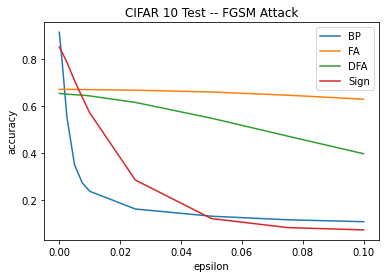

In [103]:
plot_accuracy(epsilons, 
              [
                  robust_accuracy_bp,
                  robust_accuracy_fa, 
                  robust_accuracy_dfa, 
                  robust_accuracy_sign,
                            ], 
              ['BP', 'FA', 'DFA', 'Sign'],
              'CIFAR 10 Test -- FGSM Attack',
             'epsilon')

## Big epsilons

In [75]:
epsilons = [0.0, 0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.75, 0.9, 1]

In [76]:
attack = FGSM(model_bp, eps=1/255)
model_bp = model_bp.to(device)
clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_dataset(model_bp, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.9130736


In [77]:
attack = FGSM(model_fa, eps=1/255)
model_fa = model_fa.to(device)
clean_accuracy_fa, robust_accuracy_fa = apply_attack_on_dataset(model_fa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6704905


In [78]:
attack = FGSM(model_dfa, eps=1/255, mode='DFA')
model_dfa = model_dfa.to(device)
clean_accuracy_dfa, robust_accuracy_dfa = apply_attack_on_dataset(model_dfa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6538766


In [79]:
attack = FGSM(model_sign, eps=1/255)
model_sign = model_sign.to(device)
clean_accuracy_sign, robust_accuracy_sign = apply_attack_on_dataset(model_sign, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.84483784


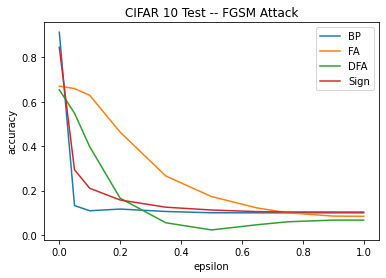

In [80]:
plot_accuracy(epsilons, 
              [
                  robust_accuracy_bp,
                  robust_accuracy_fa, 
                  robust_accuracy_dfa, 
                  robust_accuracy_sign,
                            ], 
              ['BP', 'FA', 'DFA', 'Sign'],
              'CIFAR 10 Test -- FGSM Attack',
             'epsilon')

In [88]:
attack = attack = torchattacks.FGSM(model_fa, eps=0.1)

In [89]:
images, labels = iter(test_dataloader).next()

Clean Accuracy on Batch: 0.71875%
Robust Accuracy on Batch: 0.65625%


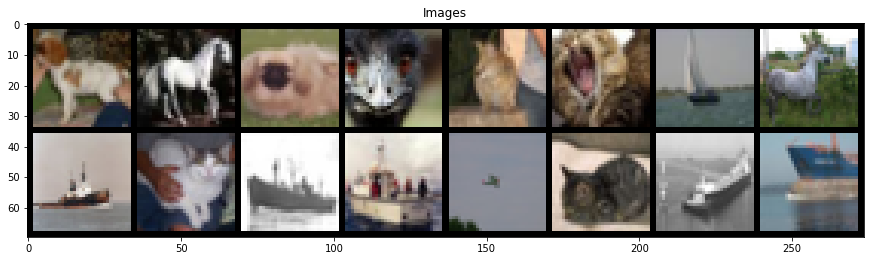

In [90]:
model_fa = model_fa.to(device)
adv_images, success, accuracy_clean, accuracy_robust = apply_attack_on_batch(model_fa, images, labels, attack, device)
plot_images = images[success]
plot_images_adv = adv_images[success]
imshow(torchvision.utils.make_grid(plot_images[0:16], normalize=False), "Images")

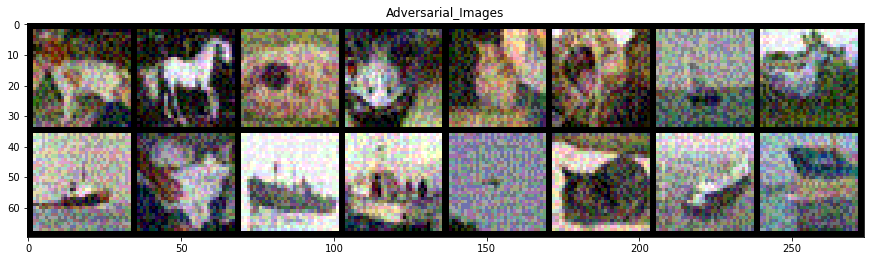

In [91]:
imshow(torchvision.utils.make_grid(plot_images_adv[0:16], normalize=False), "Adversarial_Images")